# Flight Delays

In [23]:
import pandas as pd
import glob
import os
import requests
import json
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import random
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

from keras import regularizers
from keras import models
from keras import layers
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight

import keras
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
from scipy import stats
import pickle

### Importing Prepared Data

In the first notebook, we prepared our data by engineering extra features and cleaning up missing data. We now bring that data here.

In [2]:
df = pd.read_csv('data/prepared/cleaned_data.csv')

In [3]:
# Preview what the data looks like
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14329383 entries, 0 to 14329382
Data columns (total 51 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   YEAR                        int64  
 1   MONTH                       int64  
 2   DAY_OF_MONTH                int64  
 3   DAY_OF_WEEK                 int64  
 4   MKT_CARRIER                 object 
 5   MKT_CARRIER_FL_NUM          int64  
 6   OP_CARRIER                  object 
 7   ORIGIN                      object 
 8   DEST                        object 
 9   DEP_DELAY_NEW               float64
 10  ARR_DELAY_NEW               float64
 11  CANCELLED                   float64
 12  CRS_ELAPSED_TIME            float64
 13  DISTANCE                    float64
 14  AVG_CONGESTION_TMINUS_0     float64
 15  AVG_CONGESTION_TMINUS_0-3   float64
 16  AVG_CONGESTION_TMINUS_0-6   float64
 17  AVG_CONGESTION_TMINUS_0-12  float64
 18  AWND                        float64
 19  PRCP               

In [4]:
pd.set_option('display.max_columns', 100)
df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,MKT_CARRIER,MKT_CARRIER_FL_NUM,OP_CARRIER,ORIGIN,DEST,DEP_DELAY_NEW,ARR_DELAY_NEW,CANCELLED,CRS_ELAPSED_TIME,DISTANCE,AVG_CONGESTION_TMINUS_0,AVG_CONGESTION_TMINUS_0-3,AVG_CONGESTION_TMINUS_0-6,AVG_CONGESTION_TMINUS_0-12,AWND,PRCP,SNOW,TMIN,TMAX,ELEVATION,SNWD,WDF2,WSF2,WT01,WT02,WT03,WT04,WT06,WT08,dest_AWND,dest_PRCP,dest_SNOW,dest_TMIN,dest_TMAX,dest_ELEVATION,dest_SNWD,dest_WDF2,dest_WSF2,dest_WT01,dest_WT02,dest_WT03,dest_WT04,dest_WT06,dest_WT08,days-from-specific-holiday,takeoff-mins-from-midnight,landing-mins-from-midnight
0,2018,1,1,1,B6,2704,B6,SJU,JFK,0.0,0.0,0.0,238.0,1598.0,3.333333,5.333333,13.333333,57.00,7.61,0.0,0.0,26.0,34.0,305.7,0.0,350.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,17.67,0.00,0.0,7.0,18.0,2.7,0.0,310.0,29.1,0.0,0.0,0.0,0.0,0.0,0.0,New Years Day_0.0,150,328
1,2018,1,1,1,WN,1041,WN,DCA,AUS,166.0,140.0,0.0,230.0,1315.0,17.000000,149.500000,189.000000,299.50,11.63,0.0,0.0,13.0,26.0,4.1,0.0,320.0,23.9,0.0,0.0,0.0,0.0,0.0,0.0,16.78,0.00,0.0,24.0,32.0,146.5,0.0,360.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,New Years Day_0.0,1065,1235
2,2018,1,1,1,WN,385,WN,ATL,MCO,251.0,256.0,0.0,85.0,404.0,154.250000,609.250000,746.000000,1317.50,13.20,0.0,0.0,18.0,29.0,308.2,0.0,340.0,21.9,0.0,0.0,0.0,0.0,0.0,0.0,12.75,0.07,0.0,44.0,59.0,27.1,0.0,360.0,25.1,1.0,0.0,0.0,0.0,0.0,1.0,New Years Day_0.0,1065,1150
3,2018,1,1,1,WN,1979,WN,EWR,MCO,0.0,9.0,0.0,175.0,937.0,33.250000,224.250000,279.750000,474.25,12.75,0.0,0.0,6.0,20.0,1.9,0.0,330.0,23.9,0.0,0.0,0.0,0.0,0.0,0.0,12.75,0.07,0.0,44.0,59.0,27.1,0.0,360.0,25.1,1.0,0.0,0.0,0.0,0.0,1.0,New Years Day_0.0,1065,1240
4,2018,1,1,1,WN,769,WN,DEN,HOU,45.0,22.0,0.0,145.0,883.0,130.250000,539.750000,714.000000,1144.75,5.37,0.0,0.0,3.0,28.0,1647.2,0.0,30.0,13.0,1.0,0.0,0.0,0.0,0.0,1.0,16.11,0.00,0.0,31.0,40.0,13.2,0.0,30.0,25.1,0.0,0.0,0.0,0.0,0.0,0.0,New Years Day_0.0,945,1150


### Engeneering Target

Our dataset contains departure delays in minutes (DEP_DELAY). This is a continuous variable. However, simply predicting whether there is a delay isn't useful since most users probably won't care if there is a 5 minute delay. However, there is a big difference between a 30 minute and 

Most flights have none or minimal delays. So this distribution isn't surprising. The average flight is delayed by 9 minutes, with a fairly large standard deviation of 43 minutes. Looking at the 75th percentile, just 25% of flgiths had delays over 6 minutes.

Let's zoom in on those values.

In [5]:
# Create a function to engineer this feature
def serious_delay(value):
    """
    Funtion takes in int or float and returns category of delay
    """
    if value <= 60:
        return "No"
    else:
        return "Yes"
    
df['target'] = df['ARR_DELAY_NEW'].apply(serious_delay)

In [6]:
for col in df.select_dtypes(exclude='number').columns:
    print(df[col].value_counts().sort_values())
    print('---------------')

NK     638533
AS     759504
B6     807526
UA    2513361
AA    2596778
DL    3055302
WN    3958379
Name: MKT_CARRIER, dtype: int64
---------------
AS     627900
NK     638533
B6     807526
OO    1632493
UA    1835770
AA    2373985
DL    2454797
WN    3958379
Name: OP_CARRIER, dtype: int64
---------------
OGG     37988
MEM     43029
CVG     44248
CHS     45803
OKC     54149
        ...  
DFW    567510
LAX    626535
ORD    667882
DEN    784309
ATL    941888
Name: ORIGIN, Length: 62, dtype: int64
---------------
ORH         8
DVL        15
BIH        35
TYR        41
LBL        43
        ...  
DFW    449929
ORD    523219
DEN    558406
LAX    561829
ATL    698454
Name: DEST, Length: 322, dtype: int64
---------------
Thanksgiving_-7.0      21509
Thanksgiving_0.0       29315
Memorial Day_-2.0      29378
Memorial Day_5.0       29604
Veterans Day_6.0       30535
                      ...   
New Years Day_0.0      47448
Thanksgiving_4.0       47566
Thanksgiving_-1.0      48042
Thanksgiving_3.0 

It looks like we have some destinations that are very infrequently traveled (like ORH with just 8 records). We'll filter the data to exclude these types of flights.

In [9]:
df = df.groupby('DEST').filter(lambda x: len(x) > 10000)

14 million records is also way too much for modeling. So we need to take a sample of our entire dataset.

In [10]:
df_sample = df.sample(frac=0.025, axis=0, random_state=123)
df_sample.to_csv('data/prepared/clean_data_sample.csv', index=False)

In [2]:
df_sample = pd.read_csv('data/prepared/clean_data_sample.csv')

### Splitting up data for training, validation & testing

In [3]:
# Splitting features & target
y = df_sample["target"]
X = df_sample.drop(["target"], axis=1)

# Creating train, test and validation sets

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [4]:
num_cols = ['CRS_ELAPSED_TIME',
'DISTANCE',
'AVG_CONGESTION_TMINUS_0',
'AVG_CONGESTION_TMINUS_0-3',
'AVG_CONGESTION_TMINUS_0-6',
'AVG_CONGESTION_TMINUS_0-12',
'AWND',
'PRCP',
'SNOW',
'TMIN',
'TMAX',
'ELEVATION',
'SNWD',
'WDF2',
'WSF2',
'dest_AWND',
'dest_PRCP',
'dest_SNOW',
'dest_TMIN',
'dest_TMAX',
'dest_SNWD',
'dest_WDF2',
'dest_WSF2',
'dest_ELEVATION',
'takeoff-mins-from-midnight',
'landing-mins-from-midnight']

cat_cols = ['MONTH',
'DAY_OF_MONTH',
'DAY_OF_WEEK',
'OP_CARRIER',
'ORIGIN',
'DEST',
'WT01',
'WT02',
'WT03',
'WT04',
'WT06',
'WT08',
'dest_WT01',
'dest_WT02',
'dest_WT03',
'dest_WT04',
'dest_WT06',
'dest_WT08',
'days-from-specific-holiday']

In [5]:
# Training Data

X_train_num = X_train[num_cols].copy()
X_train_cat = X_train[cat_cols].copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_num.index, columns=X_train_num.columns)

X_train_cat = X_train_cat.applymap(str)
cols = X_train_cat.columns

X_train_ohe = pd.get_dummies(X_train_cat,prefix=cols, drop_first=False)

preprocessed_data = pd.concat([X_train_ohe, X_train_scaled], axis=1)

n_features = preprocessed_data.shape[1]

# Test Data

X_valid_num = X_valid[num_cols].copy()
X_valid_cat = X_valid[cat_cols].copy()

X_valid_scaled = scaler.transform(X_valid_num)
X_valid_scaled = pd.DataFrame(X_valid_scaled, index=X_valid_num.index, columns=X_valid_num.columns)

X_valid_cat = X_valid_cat.applymap(str)
cols = X_valid_cat.columns
X_valid_ohe = pd.get_dummies(X_valid_cat,prefix=cols, drop_first=False)

preprocessed_val_data = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)

In [6]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
# class weights dict

class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# Class weight num dict
class_weights_num_dict = {0: class_weights_dict['No'],
                1: class_weights_dict['Yes']}

# Sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
valid_sample_weights = compute_sample_weight(class_weight='balanced', y=y_valid)

# Labels for deep learning
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y_train)
valid_labels = binarizer.fit_transform(y_valid)

## Modeling

### Helper Functions

In [7]:
def visualize_training_results(hist):
   
    hist_dict = hist.history
    fig, ax = plt.subplots(figsize=(12, 8))

    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)
    ax.plot(epochs, loss_values, label='Training loss')
    ax.plot(epochs, val_loss_values, label='Validation loss')

    ax.set_title('Training & validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();
   
    fig, ax = plt.subplots(figsize=(12, 8))

    acc_values = hist_dict['acc']
    val_acc_values = hist_dict['val_acc']

    ax.plot(epochs, acc_values, label='Training acc')
    ax.plot(epochs, val_acc_values, label='Validation acc')
    ax.set_title('Training & validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend();
   
def evaluate_model(model, x, y):
    """
    Describe the function -- inputs, expected output, what is model? what are x/y and expected formats
    """
    y_true = y
    
    if type(y).__module__ == np.__name__:
        predications = model.predict(x)
        l = x.shape[0] 
        y_pred = np.zeros((l, 1))
        for i in range(predications.shape[0]):
            if predications[i,0] > 0.5: 
                y_pred[i, 0] = 1
            else:
                y_pred[i, 0] = 0
        
        print('Model Scores for Validation Data:')
        print('--------------')
        accuracy = accuracy_score(y_true, y_pred)
        print('Accuracy: %.3f' % round(accuracy, 3))
        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred, pos_label=1)
        print('Precision: %.3f' % round(precision, 3))
        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred, pos_label=1)
        print('Recall: %.3f' % round(recall, 3))
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, pos_label=1)
        print('F1 score: %.3f' % round(f1, 3))
        print('--------------')
        print('Confusion Matrix:')

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
        
    else:
        y_pred  = model.predict(x)
   
        print('Model Scores for Validation Data:')
        print('--------------')
        accuracy = accuracy_score(y_true, y_pred)
        print('Accuracy: %.3f' % round(accuracy, 3))
        # precision tp / (tp + fp)
        precision = precision_score(y_true, y_pred, pos_label='Yes')
        print('Precision: %.3f' % round(precision, 3))
        # recall: tp / (tp + fn)
        recall = recall_score(y_true, y_pred, pos_label='Yes')
        print('Recall: %.3f' % round(recall, 3))
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_true, y_pred, pos_label='Yes')
        print('F1 score: %.3f' % round(f1, 3))
        print('--------------')
        print('Confusion Matrix:')

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')

### Gradient Descent

#### Logistic Regression

Model Scores for Validation Data:
--------------
Accuracy: 0.946


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.000
Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


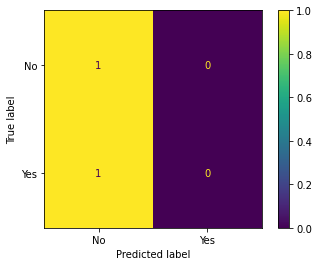

In [8]:
baselline_pipe = Pipeline(steps=[
    ('dc', DummyClassifier(strategy='most_frequent'))
])

baselline_pipe.fit(preprocessed_data, y_train)

evaluate_model(baselline_pipe, preprocessed_val_data, y_valid)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.947
Precision: 0.448
Recall: 0.007
F1 score: 0.015
--------------
Confusion Matrix:


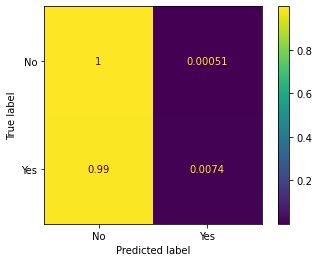

In [9]:
lr_pipe1 = Pipeline(steps=[
    ('lr', LogisticRegression(random_state=123))
])

lr_pipe1.fit(preprocessed_data, y_train)

evaluate_model(lr_pipe1, preprocessed_data, y_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Scores for Validation Data:
--------------
Accuracy: 0.690
Precision: 0.107
Recall: 0.664
F1 score: 0.185
--------------
Confusion Matrix:


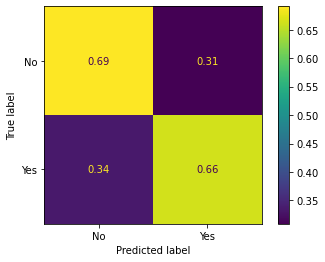

In [10]:
lr_pipe2 = Pipeline(steps=[
    ('lr', LogisticRegression(class_weight=class_weights_dict, random_state=123))
])

lr_pipe2.fit(preprocessed_data, y_train)

evaluate_model(lr_pipe2, preprocessed_data, y_train)

#### Random Forest

Model Scores for Validation Data:
--------------
Accuracy: 0.946


C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.000
Recall: 0.000
F1 score: 0.000
--------------
Confusion Matrix:


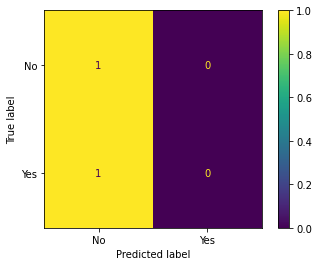

In [11]:
rf_pipe = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  random_state=123))
])

rf_pipe.fit(preprocessed_data, y_train)

evaluate_model(rf_pipe, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.798
Precision: 0.132
Recall: 0.494
F1 score: 0.209
--------------
Confusion Matrix:


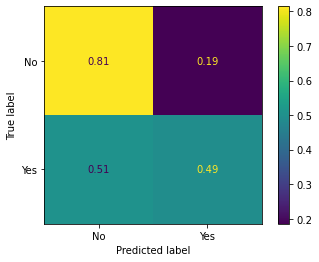

In [12]:
rf_pipe2 = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=100,
                                  max_depth=12,
                                  class_weight=class_weights_dict,
                                  random_state=123))
])

rf_pipe2.fit(preprocessed_data, y_train)

evaluate_model(rf_pipe2, preprocessed_val_data, y_valid)

#### XGBoost

Model Scores for Validation Data:
--------------
Accuracy: 0.767
Precision: 0.127
Recall: 0.565
F1 score: 0.208
--------------
Confusion Matrix:


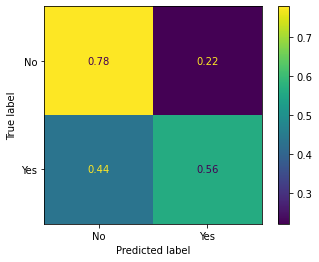

In [13]:
xgb_pipe = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier()),
])

xgb_pipe.fit(preprocessed_data, y_train, my_xgb_clf__sample_weight=sample_weights)

evaluate_model(xgb_pipe, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.946
Precision: 0.536
Recall: 0.036
F1 score: 0.068
--------------
Confusion Matrix:


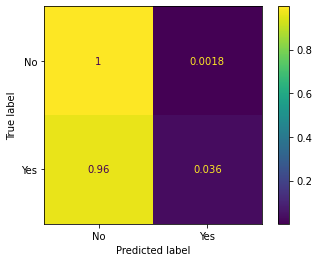

In [14]:
xgb_pipe1 = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier()),
])

xgb_pipe1.fit(preprocessed_data, y_train)

evaluate_model(xgb_pipe1, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.772
Precision: 0.128
Recall: 0.553
F1 score: 0.207
--------------
Confusion Matrix:


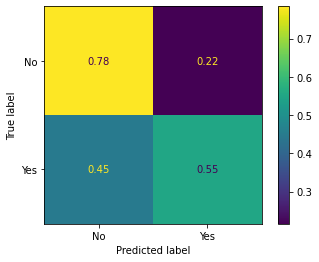

In [15]:
xgb_pipe2 = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier(subsample=0.4, max_depth=15, alpha = 100))
])

xgb_pipe2.fit(preprocessed_data,
              y_train,
              my_xgb_clf__sample_weight=sample_weights)

evaluate_model(xgb_pipe2, preprocessed_val_data, y_valid)

In [16]:
from collections import Counter
counter = Counter(y_train)
estimate = counter['No'] / counter['Yes']

Model Scores for Validation Data:
--------------
Accuracy: 0.768
Precision: 0.128
Recall: 0.571
F1 score: 0.210
--------------
Confusion Matrix:


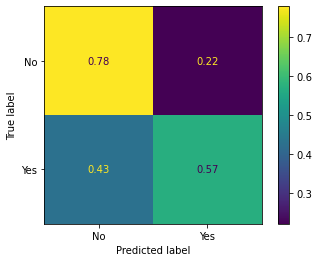

In [17]:
xgb_scaled_model = XGBClassifier(scale_pos_weight=estimate)
xgb_scaled_model.fit(preprocessed_data, y_train)

evaluate_model(xgb_scaled_model, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.732
Precision: 0.121
Recall: 0.631
F1 score: 0.203
--------------
Confusion Matrix:


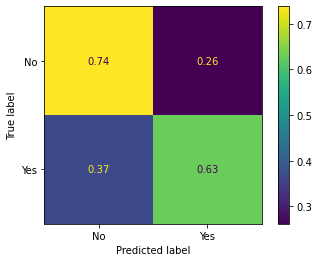

In [18]:
xgb_scaled_model2 = XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 4,
                                  eta = 0.2,
                                  nthread = 2,
                                  colsample_bytree = 0.7,
                                  gamma = 2.5,
                                  objective = "binary:logistic")

xgb_scaled_model2.fit(preprocessed_data, y_train, eval_metric=f1_score)

evaluate_model(xgb_scaled_model2, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.750
Precision: 0.124
Recall: 0.601
F1 score: 0.206
--------------
Confusion Matrix:


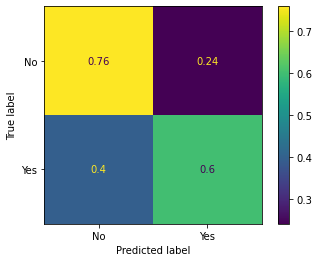

In [21]:
xgb_scaled_model3 = XGBClassifier(scale_pos_weight=estimate,
                                  max_depth = 6,
                                  eta = 0.1,
                                  nthread = 2,
                                  colsample_bytree = 0.7,
                                  gamma = 2.5,
                                  objective = "binary:logistic")

xgb_scaled_model3.fit(preprocessed_data, y_train, eval_metric=f1_score)

evaluate_model(xgb_scaled_model3, preprocessed_val_data, y_valid)

### LightGBM

Model Scores for Validation Data:
--------------
Accuracy: 0.946
Precision: 0.585
Recall: 0.017
F1 score: 0.032
--------------
Confusion Matrix:


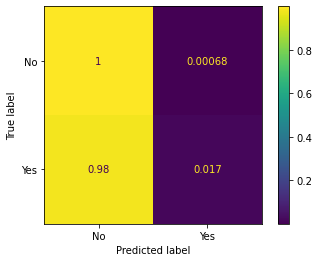

In [19]:
lgbm_model_1 = LGBMClassifier()

lgbm_model_1.fit(preprocessed_data, y_train)

evaluate_model(lgbm_model_1, preprocessed_val_data, y_valid)

Model Scores for Validation Data:
--------------
Accuracy: 0.817
Precision: 0.147
Recall: 0.496
F1 score: 0.227
--------------
Confusion Matrix:


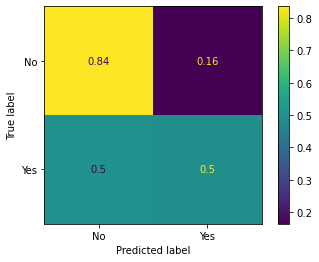

In [20]:
lgbm_model_2 = LGBMClassifier(scale_pos_weight=13,
                              learning_rate = 0.1,
                              num_leaves = 7,
                              max_depth = 3,
                              min_child_samples = 100,
                              max_bin = 100,
                              subsample = 0.7,
                              subsample_freq = 2,
                              colsample_bytree = 0.9,
                              min_child_weight = 0)

lgbm_model_2.fit(preprocessed_data, y_train)

evaluate_model(lgbm_model_2, preprocessed_val_data, y_valid)

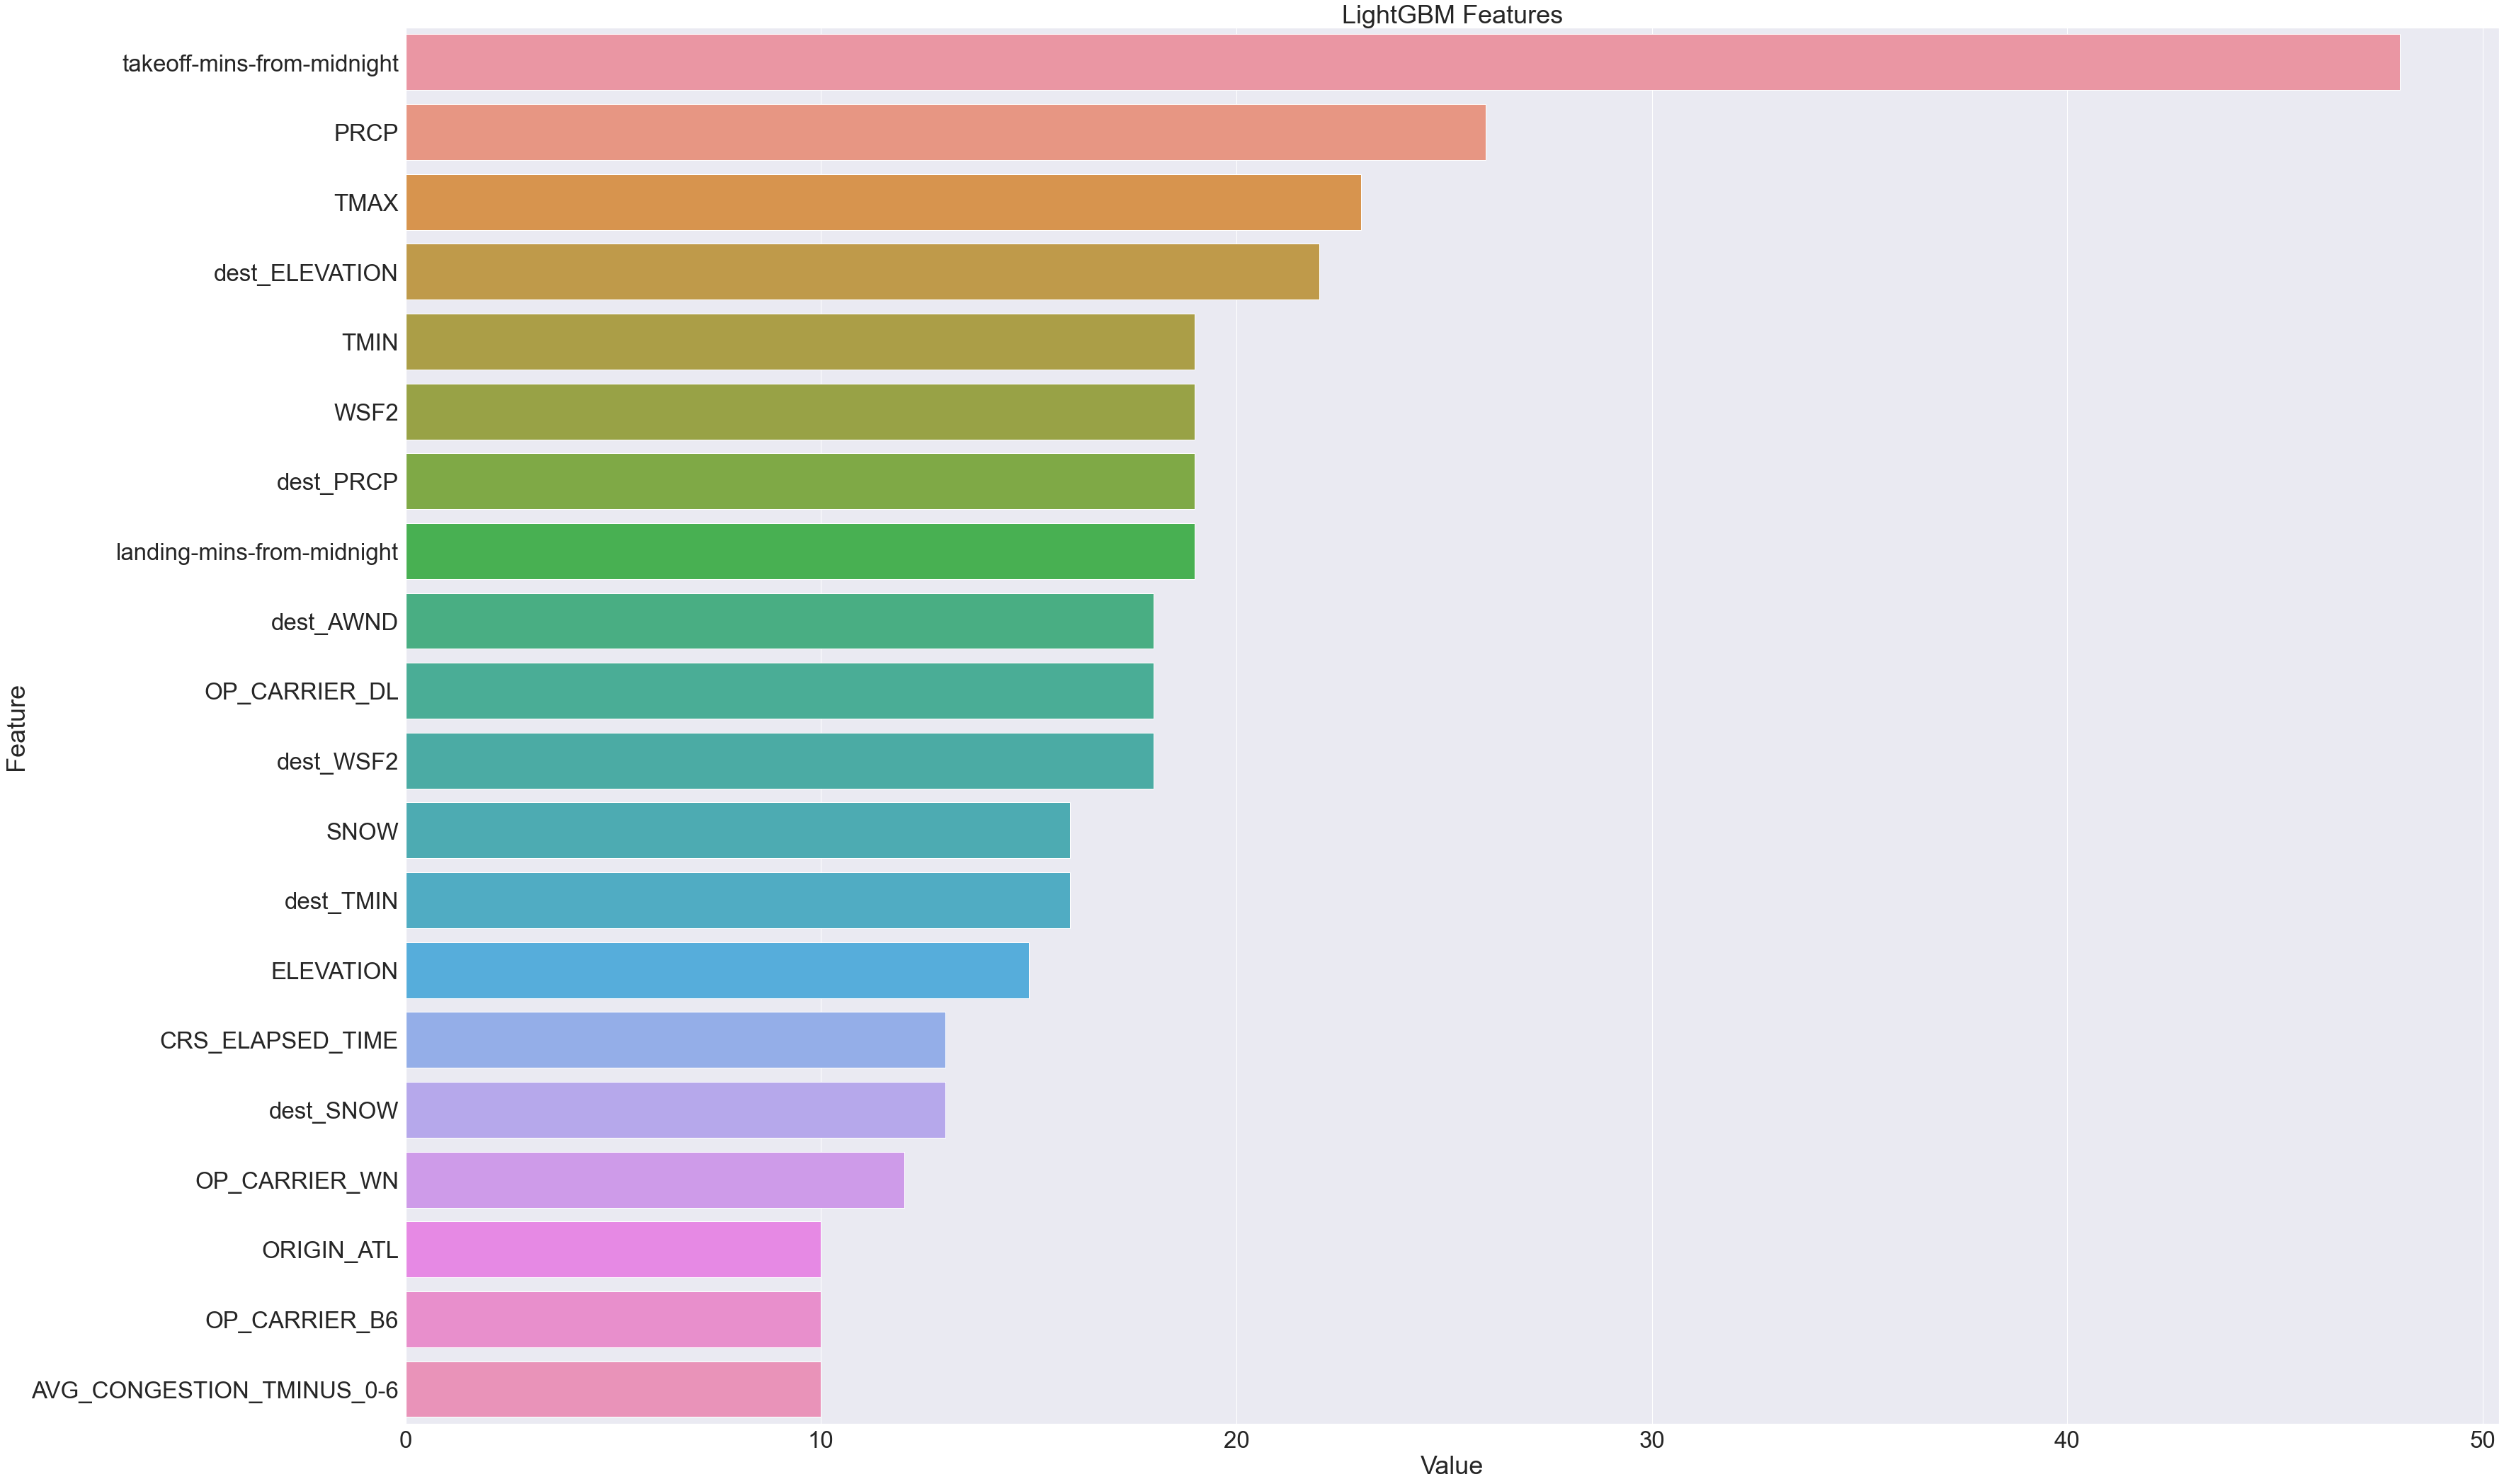

In [24]:
def plotImp(model, X , num = 20, fig_size = (50, 30)):
    boost = model.booster_
    feature_imp = pd.DataFrame({'Value':boost.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()
    
plotImp(lgbm_model_2, preprocessed_data)

In [25]:
# Saving best performing model
# save the model to disk
filename = 'model.sav'
pickle.dump(lgbm_model_2, open(filename, 'wb'))

### Deep Learning Models

In [153]:
dl_model_1 = Sequential()
dl_model_1.add(Dense(300, activation='relu', input_dim=n_features))
dl_model_1.add(Dense(150, activation='relu'))
dl_model_1.add(Dense(75, activation='relu'))
dl_model_1.add(Dense(30, activation='relu'))
dl_model_1.add(Dense(15, activation='relu'))
dl_model_1.add(Dense(1, activation='sigmoid'))

dl_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_results = dl_model_1.fit(preprocessed_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=25,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6235 - acc: 0.6984 - val_loss: 0.6083 - val_acc: 0.6646
Epoch 2/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5953 - acc: 0.7124 - val_loss: 0.5319 - val_acc: 0.7584
Epoch 3/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5783 - acc: 0.6920 - val_loss: 0.6787 - val_acc: 0.6722
Epoch 4/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5481 - acc: 0.7247 - val_loss: 0.5842 - val_acc: 0.7160
Epoch 5/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.5052 - acc: 0.7263 - val_loss: 0.5990 - val_acc: 0.6993
Epoch 6/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.4506 - acc: 0.7562 - val_loss: 0.6148 - val_acc: 0.6615
Epoch 7/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.3958 - acc: 0.7807 - val_loss: 0.5291 - val_acc: 0.7420
Epoch 8/25
2428/2428 [==============================] - 4s 2ms

380/380 [==============================] - 0s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.868
Precision: 0.144
Recall: 0.264
F1 score: 0.186
--------------
Confusion Matrix:


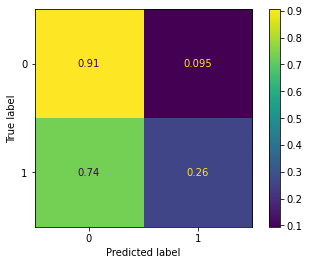

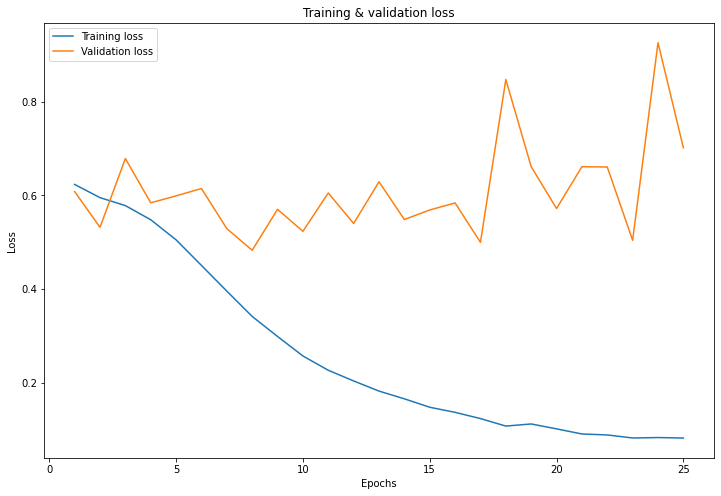

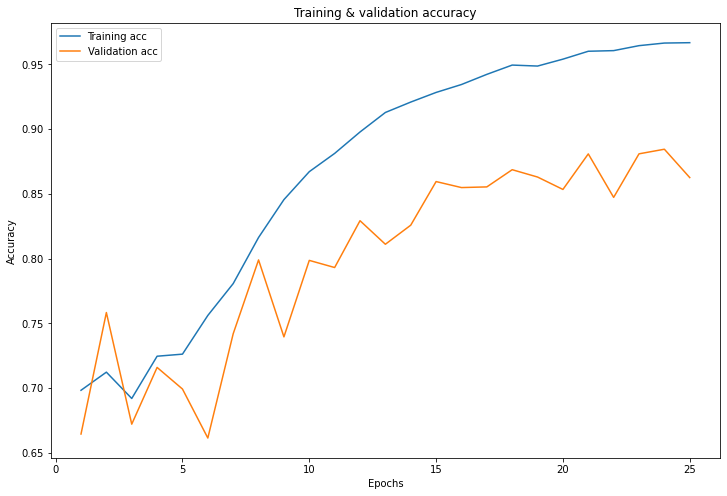

In [311]:
# Evaluate Results
evaluate_model(dl_model_1, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_1_results)

In [171]:
dl_model_1_poly = Sequential()
dl_model_1_poly.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly.add(Dense(150, activation='relu'))
dl_model_1_poly.add(Dense(75, activation='relu'))
dl_model_1_poly.add(Dense(30, activation='relu'))
dl_model_1_poly.add(Dense(15, activation='relu'))
dl_model_1_poly.add(Dense(1, activation='sigmoid'))

dl_model_1_poly.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_results = dl_model_1_poly.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=50,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/50
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6335 - acc: 0.6623 - val_loss: 0.5814 - val_acc: 0.6650
Epoch 2/50
2428/2428 [==============================] - 6s 3ms/step - loss: 0.6174 - acc: 0.6741 - val_loss: 0.6444 - val_acc: 0.7016
Epoch 3/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6019 - acc: 0.6971 - val_loss: 0.5936 - val_acc: 0.6764
Epoch 4/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5942 - acc: 0.6957 - val_loss: 0.6409 - val_acc: 0.6746
Epoch 5/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5838 - acc: 0.6993 - val_loss: 0.6618 - val_acc: 0.5864
Epoch 6/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5760 - acc: 0.7005 - val_loss: 0.6383 - val_acc: 0.6715
Epoch 7/50
2428/2428 [==============================] - 7s 3ms/step - loss: 0.5708 - acc: 0.7060 - val_loss: 0.5445 - val_acc: 0.7240
Epoch 8/50
2428/2428 [==============================] - 6s 3ms

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.883
Precision: 0.143
Recall: 0.212
F1 score: 0.171
--------------
Confusion Matrix:


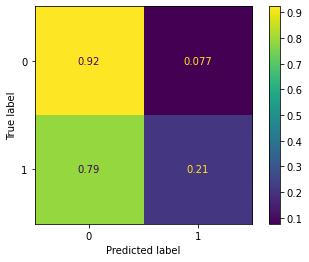

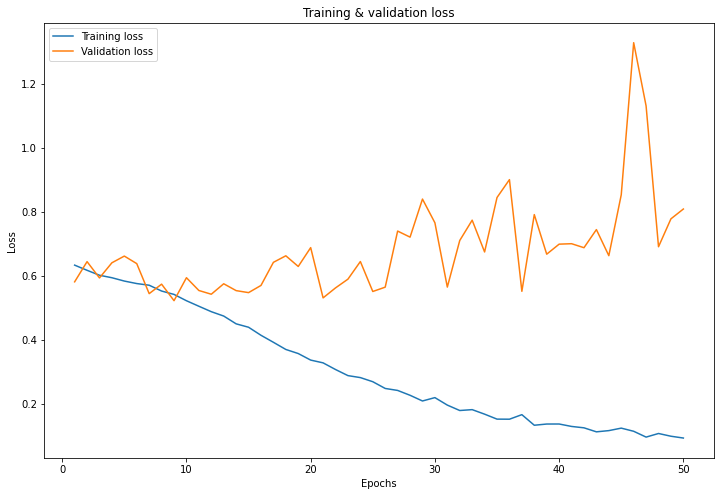

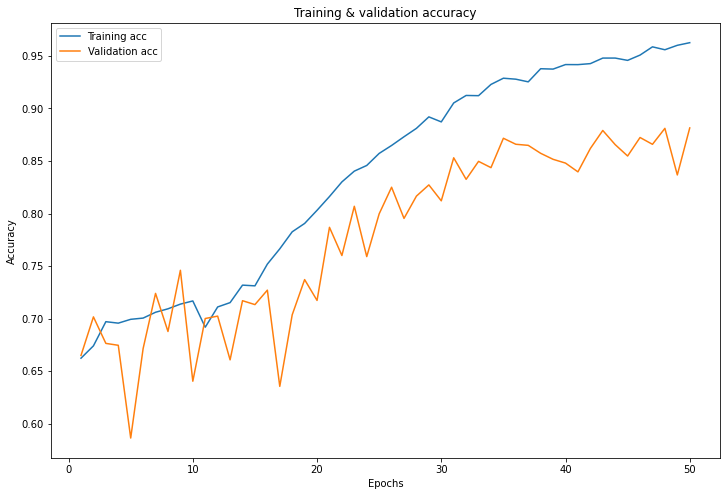

In [312]:
# Evaluate Results
evaluate_model(dl_model_1_poly, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_results)

In [155]:
dl_model_2 = Sequential()
dl_model_2.add(Dense(300, kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(0.001),
                     activation='relu',
                     input_shape=(n_features,)))
dl_model_2.add(Dense(150, activation='relu'))
dl_model_2.add(Dense(75, activation='relu'))
dl_model_2.add(Dense(30, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dl_model_2.add(Dense(15, activation='relu'))
dl_model_2.add(Dense(1, activation='sigmoid'))

dl_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_2_results = dl_model_2.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_num_dict,
                           epochs=25,
                           batch_size=32,
                           validation_split=0.2)

Epoch 1/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6894 - acc: 0.6916 - val_loss: 0.6831 - val_acc: 0.6039
Epoch 2/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6327 - acc: 0.6999 - val_loss: 0.6490 - val_acc: 0.6772
Epoch 3/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6253 - acc: 0.7035 - val_loss: 0.7051 - val_acc: 0.6093
Epoch 4/25
2428/2428 [==============================] - 6s 2ms/step - loss: 0.6183 - acc: 0.7031 - val_loss: 0.6793 - val_acc: 0.6714
Epoch 5/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6149 - acc: 0.7166 - val_loss: 0.6100 - val_acc: 0.7405
Epoch 6/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6114 - acc: 0.7237 - val_loss: 0.6378 - val_acc: 0.7014
Epoch 7/25
2428/2428 [==============================] - 5s 2ms/step - loss: 0.6105 - acc: 0.7210 - val_loss: 0.5521 - val_acc: 0.7242
Epoch 8/25
2428/2428 [==============================] - 5s 2ms

380/380 [==============================] - 0s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.723
Precision: 0.101
Recall: 0.486
F1 score: 0.167
--------------
Confusion Matrix:


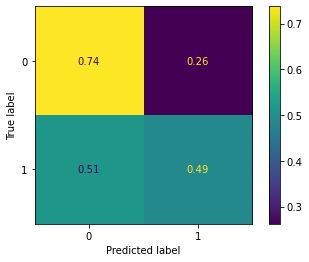

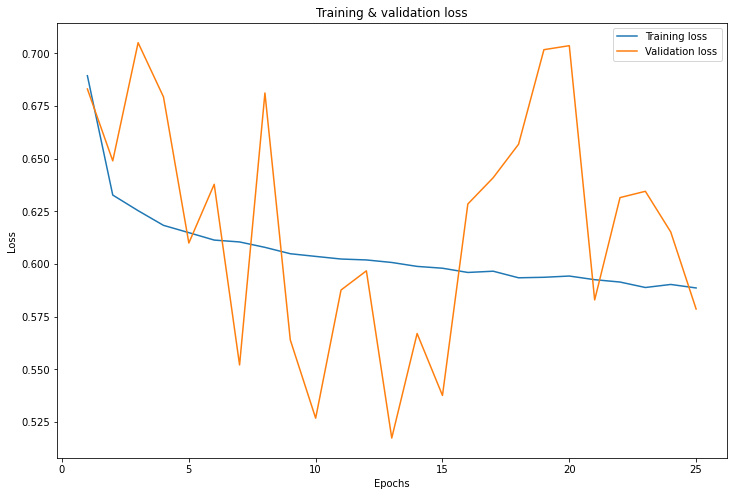

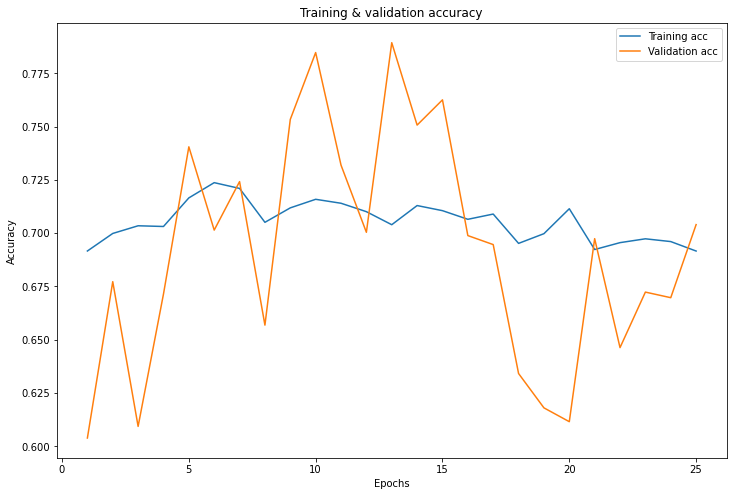

In [313]:
# Evaluate Results
evaluate_model(dl_model_2, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_2_results)

In [206]:
dl_model_3 = Sequential()
dl_model_3.add(Dense(300, kernel_initializer='he_normal',
                     kernel_regularizer=regularizers.l2(0.001),
                     activation='relu',
                     input_shape=(n_features,)))
dl_model_3.add(Dense(150, activation='relu'))
dl_model_3.add(Dense(75, activation='relu'))
dl_model_3.add(Dense(30, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
dl_model_3.add(Dense(15, activation='relu'))
dl_model_3.add(Dense(1, activation='sigmoid'))

dl_model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_3_results = dl_model_2.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_num_dict,
                           epochs=100,
                           batch_size=100,
                           validation_split=0.2)

Epoch 1/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5617 - acc: 0.7078 - val_loss: 0.6077 - val_acc: 0.6797
Epoch 2/100
777/777 [==============================] - 2s 3ms/step - loss: 0.5560 - acc: 0.6976 - val_loss: 0.5948 - val_acc: 0.6942
Epoch 3/100
777/777 [==============================] - 2s 3ms/step - loss: 0.5530 - acc: 0.6952 - val_loss: 0.6282 - val_acc: 0.6599
Epoch 4/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5490 - acc: 0.6897 - val_loss: 0.6134 - val_acc: 0.6612
Epoch 5/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5467 - acc: 0.6850 - val_loss: 0.6135 - val_acc: 0.6730
Epoch 6/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5446 - acc: 0.6875 - val_loss: 0.6310 - val_acc: 0.6323
Epoch 7/100
777/777 [==============================] - 3s 3ms/step - loss: 0.5423 - acc: 0.6840 - val_loss: 0.6065 - val_acc: 0.6424
Epoch 8/100
777/777 [==============================] - 3s 3ms/step - 

380/380 [==============================] - 1s 1ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.101
Precision: 0.056
Recall: 0.925
F1 score: 0.105
--------------
Confusion Matrix:


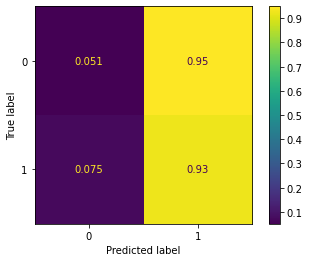

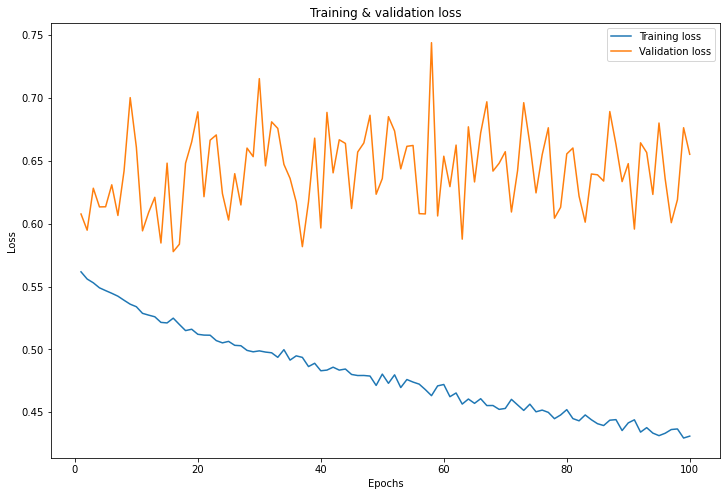

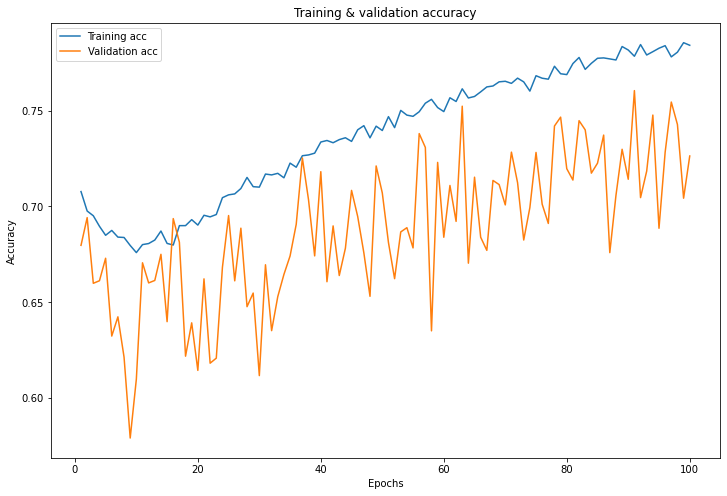

In [314]:
# Evaluate Results
evaluate_model(dl_model_3, preprocessed_val_data, valid_labels)
visualize_training_results(dl_model_3_results)

In [175]:
dl_model_1_poly_2 = Sequential()
dl_model_1_poly_2.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly_2.add(Dense(150, activation='relu'))
dl_model_1_poly_2.add(Dense(75, activation='relu'))
dl_model_1_poly_2.add(Dense(30, activation='relu'))
dl_model_1_poly_2.add(Dense(15, activation='relu'))
dl_model_1_poly_2.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_2_results = dl_model_1_poly_2.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6391 - acc: 0.6488 - val_loss: 0.6745 - val_acc: 0.6418
Epoch 2/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6177 - acc: 0.6784 - val_loss: 0.6295 - val_acc: 0.6760
Epoch 3/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.6036 - acc: 0.6890 - val_loss: 0.6816 - val_acc: 0.6552
Epoch 4/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5950 - acc: 0.6759 - val_loss: 0.5557 - val_acc: 0.6124
Epoch 5/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5895 - acc: 0.6895 - val_loss: 0.6212 - val_acc: 0.6540
Epoch 6/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5768 - acc: 0.6908 - val_loss: 0.5617 - val_acc: 0.7153
Epoch 7/100
2428/2428 [==============================] - 6s 3ms/step - loss: 0.5678 - acc: 0.6949 - val_loss: 0.6035 - val_acc: 0.6932
Epoch 8/100
2428/2428 [==============================] 

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.883
Precision: 0.124
Recall: 0.171
F1 score: 0.144
--------------
Confusion Matrix:


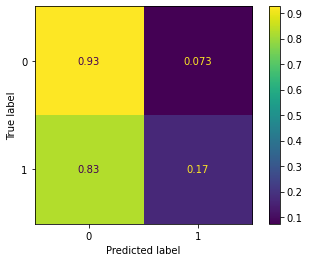

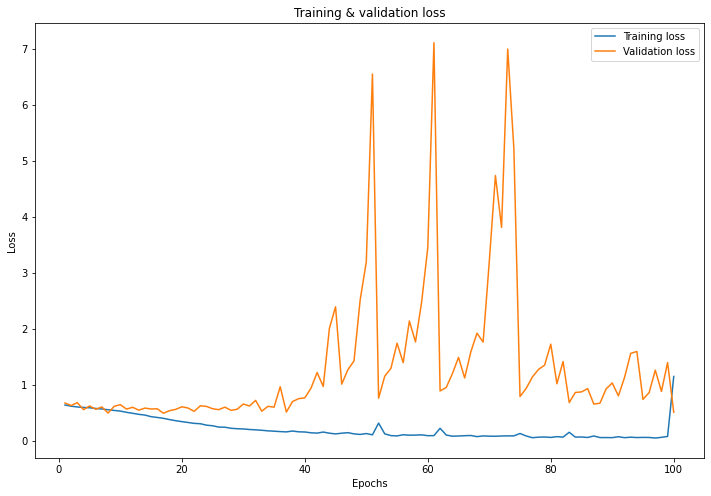

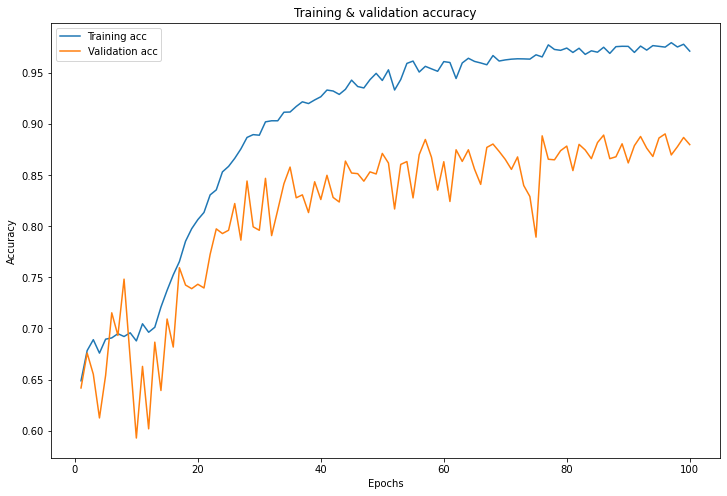

In [315]:
# Evaluate Results
evaluate_model(dl_model_1_poly_2, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_2_results)

In [178]:
dl_model_1_poly_2_reg = Sequential()
dl_model_1_poly_2_reg.add(Dense(300, activation='relu', input_dim=n_features_poly))
dl_model_1_poly_2_reg.add(layers.Dropout(0.3))
dl_model_1_poly_2_reg.add(Dense(150, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(75, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(30, activation='relu'))
dl_model_1_poly_2_reg.add(layers.Dropout(0.3))
dl_model_1_poly_2_reg.add(Dense(15, activation='relu'))
dl_model_1_poly_2_reg.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_2_reg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_2_reg_results = dl_model_1_poly_2_reg.fit(preprocessed_poly2_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=32,
                                    validation_split=0.2)

Epoch 1/100
2428/2428 [==============================] - 8s 3ms/step - loss: 0.6501 - acc: 0.6505 - val_loss: 0.5360 - val_acc: 0.8054
Epoch 2/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6301 - acc: 0.6979 - val_loss: 0.6074 - val_acc: 0.6998
Epoch 3/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6205 - acc: 0.6994 - val_loss: 0.6233 - val_acc: 0.6852
Epoch 4/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6120 - acc: 0.6962 - val_loss: 0.5841 - val_acc: 0.7371
Epoch 5/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6082 - acc: 0.6927 - val_loss: 0.5063 - val_acc: 0.7646
Epoch 6/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6054 - acc: 0.6878 - val_loss: 0.5105 - val_acc: 0.8449
Epoch 7/100
2428/2428 [==============================] - 7s 3ms/step - loss: 0.6024 - acc: 0.6800 - val_loss: 0.5685 - val_acc: 0.6912
Epoch 8/100
2428/2428 [==============================] 

380/380 [==============================] - 1s 2ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.875
Precision: 0.147
Recall: 0.248
F1 score: 0.185
--------------
Confusion Matrix:


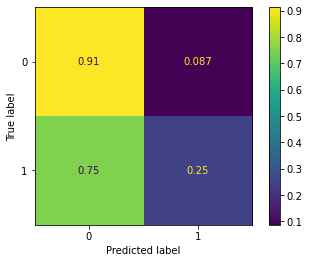

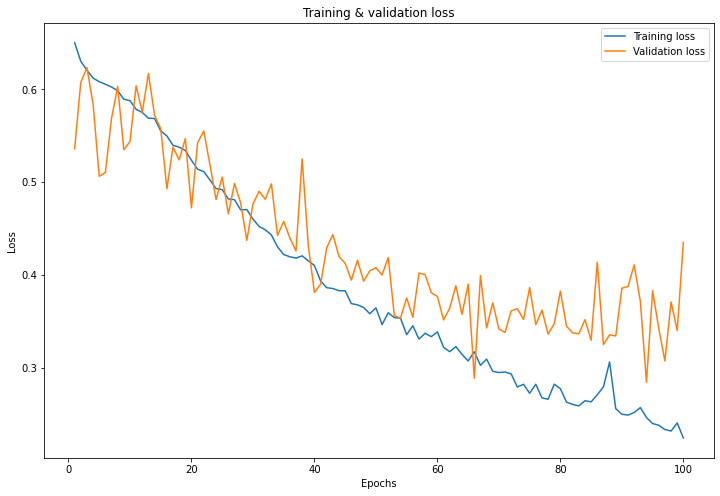

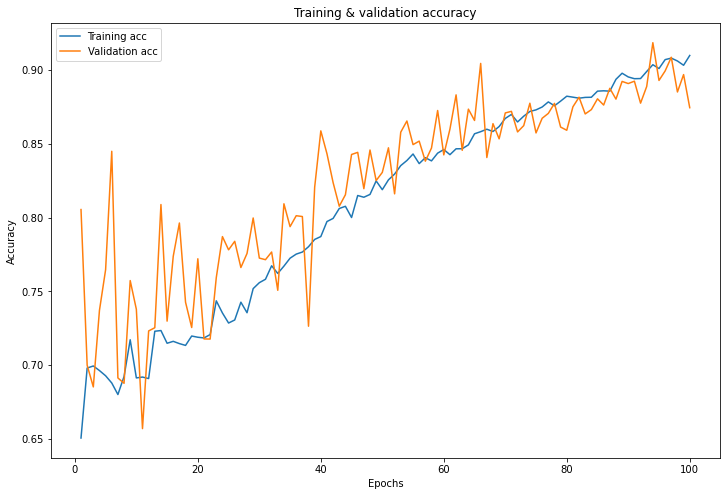

In [316]:
evaluate_model(dl_model_1_poly_2_reg, preprocessed_poly2_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_2_reg_results)

380/380 [==============================] - 1s 2ms/step


Text(0, 0.5, 'Number of Predictions')

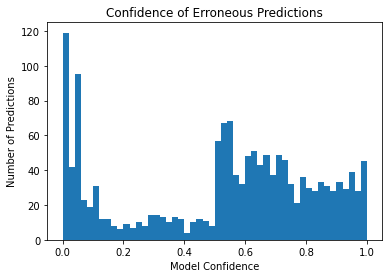

In [318]:
preds = dl_model_1_poly_2_reg.predict(preprocessed_poly2_val_data)
preds_int = np.zeros((preprocessed_poly2_val_data.shape[0] , 1))
for i in range(preds_int.shape[0]):
    if preds[i,0] > 0.5: 
        preds_int[i, 0] = 1
    else:
        preds_int[i, 0] = 0

wrong_predictions = []

for i in range(preds.shape[0]):
    if preds_int[i, 0] == valid_labels[i,0]: 
        pass
    else:
        wrong_predictions.append(preds[i,0])

# matplotlib histogram
plt.hist(wrong_predictions, bins = 50)
plt.title('Confidence of Erroneous Predictions')
plt.xlabel('Model Confidence')
plt.ylabel('Number of Predictions')

Looks like the model pretty uniformly struggles with predicting positive cases, and there is a big number instances (200+) where the model is almost confident there will be no delay and there is.

In [204]:
dl_model_1_poly_3 = Sequential()
dl_model_1_poly_3.add(Dense(2900, activation='relu', input_dim=n_features_poly3))
dl_model_1_poly_3.add(Dense(1500, activation='relu'))
dl_model_1_poly_3.add(Dense(750, activation='relu'))
dl_model_1_poly_3.add(Dense(250, activation='relu'))
dl_model_1_poly_3.add(Dense(100, activation='relu'))
dl_model_1_poly_3.add(Dense(50, activation='relu'))
dl_model_1_poly_3.add(Dense(1, activation='sigmoid'))

dl_model_1_poly_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

dl_model_1_poly_3_results = dl_model_1_poly_3.fit(preprocessed_poly3_data,
                                    labels,
                                    class_weight=class_weights_num_dict,
                                    epochs=100,
                                    batch_size=1000,
                                    validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 15s 186ms/step - loss: 0.6771 - acc: 0.6536 - val_loss: 0.6478 - val_acc: 0.6807
Epoch 2/100
78/78 [==============================] - 11s 147ms/step - loss: 0.6234 - acc: 0.6882 - val_loss: 0.7430 - val_acc: 0.5528
Epoch 3/100
78/78 [==============================] - 13s 164ms/step - loss: 0.6184 - acc: 0.6754 - val_loss: 0.5305 - val_acc: 0.7515
Epoch 4/100
78/78 [==============================] - 12s 159ms/step - loss: 0.6099 - acc: 0.6819 - val_loss: 0.6014 - val_acc: 0.6494
Epoch 5/100
78/78 [==============================] - 13s 162ms/step - loss: 0.6051 - acc: 0.6958 - val_loss: 0.5780 - val_acc: 0.6919
Epoch 6/100
78/78 [==============================] - 13s 163ms/step - loss: 0.5988 - acc: 0.6882 - val_loss: 0.7075 - val_acc: 0.6381
Epoch 7/100
78/78 [==============================] - 13s 161ms/step - loss: 0.5925 - acc: 0.7063 - val_loss: 0.6684 - val_acc: 0.6386
Epoch 8/100
78/78 [==============================] - 13s 161ms

Epoch 62/100
78/78 [==============================] - 12s 150ms/step - loss: 0.1653 - acc: 0.9103 - val_loss: 0.8679 - val_acc: 0.8364
Epoch 63/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1750 - acc: 0.9062 - val_loss: 0.6383 - val_acc: 0.8203
Epoch 64/100
78/78 [==============================] - 12s 153ms/step - loss: 0.1872 - acc: 0.8986 - val_loss: 0.6922 - val_acc: 0.8154
Epoch 65/100
78/78 [==============================] - 12s 153ms/step - loss: 0.1633 - acc: 0.9140 - val_loss: 0.8325 - val_acc: 0.8321
Epoch 66/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1763 - acc: 0.9083 - val_loss: 0.6843 - val_acc: 0.8358
Epoch 67/100
78/78 [==============================] - 12s 151ms/step - loss: 0.1503 - acc: 0.9219 - val_loss: 0.7412 - val_acc: 0.8334
Epoch 68/100
78/78 [==============================] - 12s 152ms/step - loss: 0.1340 - acc: 0.9254 - val_loss: 0.7996 - val_acc: 0.8528
Epoch 69/100
78/78 [==============================] - 1

380/380 [==============================] - 4s 11ms/step
Model Scores for Validation Data:
--------------
Accuracy: 0.875
Precision: 0.121
Recall: 0.187
F1 score: 0.147
--------------
Confusion Matrix:


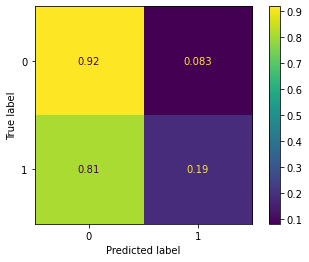

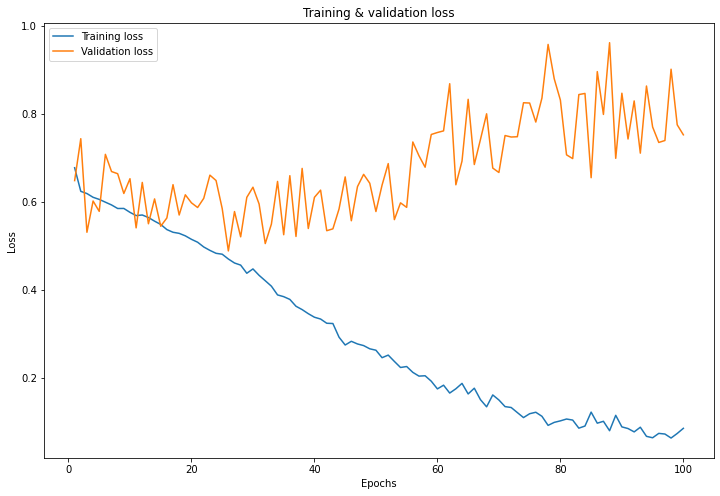

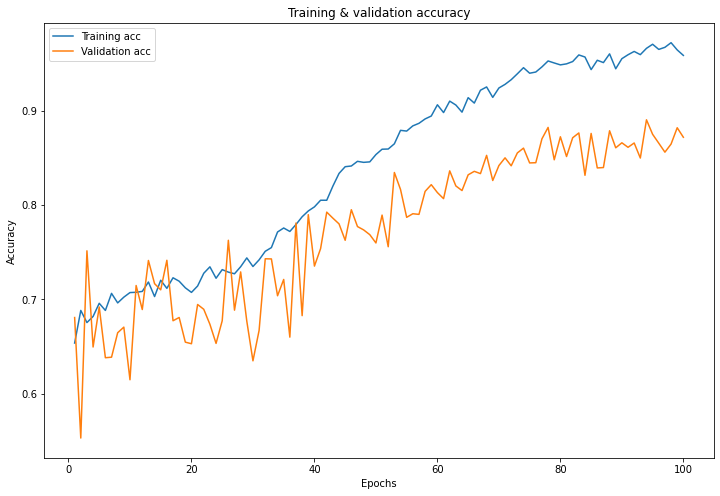

In [317]:
evaluate_model(dl_model_1_poly_3, preprocessed_poly3_val_data, valid_labels)
visualize_training_results(dl_model_1_poly_3_results)